In [1]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scripts import bookdatafunctions as bdf
from pprint import pprint
from collections import Counter

In [2]:
#Constants
#Change these and some of the code blocks if you want to view the versions with features!
AGE_FOLDER = "Data_v1-1/ages_csv/"
GROUPS_FOLDER = "Data_v1-1/groups_csv/"
REGISTERS_FOLDER = "Data_v1-1/genres_csv/"
WHOLE_FOLDER = "Data_v1-1/whole_csv/"
SHEET_NAMES_AGES = ['5','6','7','8','9','10','11','12','13','14','15']
SHEET_NAMES_GROUPS = ['7-8','9-12','13+']
SHEET_NAMES_REGISTERS = ['Fiction', 'Nonfiction', 'Textbook']
WHOLE = ['Whole']
UPOS_TAGS = {'ADJ','ADP','ADV','AUX','CCONJ','INTJ','NOUN','NUM','PRON','PROPN','PUNCT','SCONJ','SYM','VERB'}

In [3]:
#Read CSV-files into dictionaries
dfs_ages = {}
for sheet in SHEET_NAMES_AGES:
     dfs_ages[sheet] = pd.read_csv(AGE_FOLDER+sheet+".csv", sep=';', keep_default_na=False)
dfs_groups = {}
for sheet in SHEET_NAMES_GROUPS:
     dfs_groups[sheet] = pd.read_csv(GROUPS_FOLDER+sheet+".csv", sep=';', keep_default_na=False)
dfs_registers = {}
for sheet in SHEET_NAMES_REGISTERS:
     dfs_registers[sheet] = pd.read_csv(REGISTERS_FOLDER+sheet+".csv", sep=';', keep_default_na=False)
dfs_whole = {}
dfs_whole['Whole'] = pd.read_csv(WHOLE_FOLDER+"Whole.csv", sep=';', keep_default_na=False)

In [4]:
#Column names of the CSV-files
print(list(dfs_ages.values())[0].columns)

Index(['text', 'lemma', 'upos', 'Word-POS F', 'Word F', 'Word CD', 'Word D',
       'Word U', 'Word SFI', 'Word Zipf', 'Lemma F', 'Lemma CD', 'Lemma D',
       'Lemma U', 'Lemma SFI', 'Lemma Zipf', 'Lemma MPS', 'Word Syllables',
       'Word Length', 'Lemma Length', 'Word FSA', 'Lemma FSA'],
      dtype='object')


# Raw frequencies

In [5]:
#Print out raw frequency statistics displayed in Tables 2, 3, and 4 of the original paper
def formatRawFrequencyTable(dfs, names):
    dfs = dfs.copy()
    returnable = {}
    #Use this if you're viewing CSV files with features
    #word_amounts = {sheet:dfs[sheet].drop_duplicates(['text','upos+features'])['Word-POS+FEATS F'].sum() for sheet in names}
    word_amounts = {sheet:dfs[sheet].drop_duplicates(['text','upos'])['Word-POS F'].sum() for sheet in names}
    word_types = {sheet:len(dfs[sheet]['text'].drop_duplicates()) for sheet in names}
    hapax_words = {sheet:len(dfs[sheet][dfs[sheet]['Word F'] == 1].drop_duplicates('text')) for sheet in names}
    lemma_types = {sheet:len(dfs[sheet]['lemma'].drop_duplicates()) for sheet in names}
    hapax_lemmas = {sheet:len(dfs[sheet][dfs[sheet]['Lemma F'] == 1].drop_duplicates('lemma')) for sheet in names}
    for sheet in names:
        returnable[sheet] = str(sheet)+" & "+str(word_amounts[sheet])+" & "+str(word_types[sheet])+" & "+str(hapax_words[sheet])+" & "+str(lemma_types[sheet])+" \\\\"+str(hapax_lemmas[sheet])
    return returnable

In [6]:
temp = list(formatRawFrequencyTable(dfs_ages, SHEET_NAMES_AGES).values())
#temp.sort()
for i in temp:
    print("Age "+i)

Age 5 & 264916 & 51882 & 34652 & 23617 \\13798
Age 6 & 359346 & 58280 & 36711 & 23782 \\12812
Age 7 & 1342564 & 145063 & 87494 & 58820 \\32196
Age 8 & 2154478 & 192450 & 113310 & 74552 \\40219
Age 9 & 1956108 & 183459 & 107228 & 71867 \\38748
Age 10 & 2307418 & 196289 & 113091 & 72031 \\37533
Age 11 & 804251 & 108351 & 66066 & 44029 \\23381
Age 12 & 2225593 & 206401 & 122373 & 77871 \\41797
Age 13 & 2259877 & 228142 & 135717 & 85602 \\46384
Age 14 & 3007987 & 266703 & 157584 & 103280 \\56171
Age 15 & 3525859 & 282057 & 164849 & 107328 \\57987


In [7]:
temp = list(formatRawFrequencyTable(dfs_groups, SHEET_NAMES_GROUPS).values())
#temp.sort()
for i in temp:
    print("Age "+i)

Age 7-8 & 4121304 & 309559 & 181593 & 122876 \\68316
Age 9-12 & 7293370 & 440792 & 249379 & 167916 \\91213
Age 13+ & 8793723 & 528803 & 300774 & 202000 \\110446


In [8]:
temp = list(formatRawFrequencyTable(dfs_registers, SHEET_NAMES_REGISTERS).values())
#temp.sort()
for i in temp:
    print(i)

Fiction & 17064628 & 705439 & 395954 & 268981 \\148966
Nonfiction & 942972 & 159091 & 102369 & 68222 \\39699
Textbook & 2200797 & 248573 & 144000 & 106645 \\58115


In [9]:
temp = list(formatRawFrequencyTable(dfs_whole, WHOLE).values())
#temp.sort()
for i in temp:
    print(i)

Whole & 20208397 & 887782 & 500874 & 352167 \\197633


### Code for detecting hapax lemmas that are likely lemmatization mistakes

In [10]:
"""
df = dfs_whole['Whole'].copy()

hapax_lemmas = df[df['Lemma F'] == 1].drop_duplicates('lemma')
hapax_lemmas_exc_etc = df[(df['Lemma F'] == 1) & (df['upos'] != "PUNCT") & (df['upos'] != "SYM") & (df['upos'] != "X") & (df['upos'] != "_")].drop_duplicates('lemma')

print(len(hapax_lemmas))
print(len(hapax_lemmas_exc_etc))

hapax_lemma_multi_word = df[(df['Lemma F'] == 1) & (df['Word F'] > 1) & (df['Word-POS F'] < 10)].drop_duplicates('lemma')
for i in range(len(hapax_lemma_multi_word)):
    print("Word: ",hapax_lemma_multi_word.iloc[i]['text']," and Lemma: ",hapax_lemma_multi_word.iloc[i]['lemma'])
print(len(hapax_lemma_multi_word))
"""

'\ndf = dfs_whole[\'Whole\'].copy()\n\nhapax_lemmas = df[df[\'Lemma F\'] == 1].drop_duplicates(\'lemma\')\nhapax_lemmas_exc_etc = df[(df[\'Lemma F\'] == 1) & (df[\'upos\'] != "PUNCT") & (df[\'upos\'] != "SYM") & (df[\'upos\'] != "X") & (df[\'upos\'] != "_")].drop_duplicates(\'lemma\')\n\nprint(len(hapax_lemmas))\nprint(len(hapax_lemmas_exc_etc))\n\nhapax_lemma_multi_word = df[(df[\'Lemma F\'] == 1) & (df[\'Word F\'] > 1) & (df[\'Word-POS F\'] < 10)].drop_duplicates(\'lemma\')\nfor i in range(len(hapax_lemma_multi_word)):\n    print("Word: ",hapax_lemma_multi_word.iloc[i][\'text\']," and Lemma: ",hapax_lemma_multi_word.iloc[i][\'lemma\'])\nprint(len(hapax_lemma_multi_word))\n'

# POS-tags

In [11]:
#Function for formatting text to get a POS proportion table as in the original paper
#Edit this if you want to view the versions with features
def formatPOSProportions(dfs, names):
    returnable = {}
    word_amounts = {sheet:dfs[sheet]['Word-POS F'].sum() for sheet in names}
    for tag in UPOS_TAGS:
        text = tag+" "
        for sheet in names:
            df = dfs[sheet]
            text += "& "+str(round(((df[df['upos'] == tag]['Word-POS F'].sum())/word_amounts[sheet])*100, ndigits=1))+" "
        returnable[tag] = text+"\\\\"
    return returnable

In [12]:
#For age groups
temp = list(formatPOSProportions(dfs_groups, SHEET_NAMES_GROUPS).values())
temp.sort()
for i in temp:
    print(i)

ADJ & 5.5 & 5.1 & 5.3 \\
ADP & 1.4 & 1.4 & 1.4 \\
ADV & 8.8 & 8.7 & 8.7 \\
AUX & 6.4 & 6.7 & 6.8 \\
CCONJ & 3.8 & 3.9 & 3.9 \\
INTJ & 0.4 & 0.3 & 0.3 \\
NOUN & 19.4 & 19.3 & 19.7 \\
NUM & 0.8 & 0.7 & 0.8 \\
PRON & 9.9 & 10.7 & 10.6 \\
PROPN & 4.9 & 4.5 & 4.0 \\
PUNCT & 19.8 & 19.5 & 19.6 \\
SCONJ & 2.3 & 2.4 & 2.5 \\
SYM & 0.2 & 0.3 & 0.3 \\
VERB & 16.2 & 16.2 & 15.8 \\


In [13]:
#Checking statistical significance

def getPosProps(dfs, names):
    returnable = {}
    word_amounts = {sheet:dfs[sheet]['Word-POS F'].sum() for sheet in names}
    for sheet in names:
        arrs = []
        df = dfs[sheet]
        for tag in UPOS_TAGS:
            arrs.append(((df[df['upos'] == tag]['Word-POS F'].sum())/word_amounts[sheet])*100)
        returnable[sheet] = np.array(arrs)
    return returnable


props = getPosProps(dfs_groups, SHEET_NAMES_GROUPS)

In [14]:
row_wise_vars = []
for x in range(len(UPOS_TAGS)):
    temp_row = []
    for y in props:
        arr = props[y]
        temp_row.append(arr[x])
    row_wise_vars.append(np.array(temp_row))
pprint(row_wise_vars)
np.array([0,0.2,])
#pprint(np.corrcoef(np.array(row_wise_vars)))

[array([6.35785159, 6.67235405, 6.79111058]),
 array([5.46625514, 5.11621309, 5.3119019 ]),
 array([3.8385906 , 3.87036549, 3.94635478]),
 array([19.4426366 , 19.3237688 , 19.69667912]),
 array([1.36013261, 1.44554094, 1.38644539]),
 array([19.76022087, 19.47300519, 19.64686283]),
 array([0.20336473, 0.33940573, 0.28713617]),
 array([4.87470777, 4.54677231, 4.04951694]),
 array([8.80225086, 8.73257817, 8.68350405]),
 array([ 9.94092957, 10.65687248, 10.5951762 ]),
 array([16.22300413, 16.16069221, 15.75722713]),
 array([0.3909767 , 0.30718623, 0.33023955]),
 array([2.29318243, 2.42367626, 2.45576431]),
 array([0.84614469, 0.73945436, 0.80916843])]


array([0. , 0.2])

In [15]:
#For whole lexicon
temp = list(formatPOSProportions(dfs_whole, WHOLE).values())
temp.sort()
for i in temp:
    print(i)

ADJ & 5.2 \\
ADP & 1.4 \\
ADV & 8.6 \\
AUX & 6.7 \\
CCONJ & 3.9 \\
INTJ & 0.4 \\
NOUN & 19.6 \\
NUM & 0.8 \\
PRON & 11.0 \\
PROPN & 4.3 \\
PUNCT & 19.4 \\
SCONJ & 2.4 \\
SYM & 0.3 \\
VERB & 15.8 \\


# Other statistical data

In [16]:
#Function for outputting text for any wanted statistic in TCBLex as displayed in the original paper
STATISTICAL_TABLE_ROWs = ['M', 'SD', 'Min', 'P10', 'P25', 'P50', 'P75', 'P90', 'Max']
def formatStatisticalDataTypeLevel(dfs, column: str, names, table_format: bool=True, ignore_non_word: bool=False, ignore_len_one: bool=False):
    temp = {}
    duplicate_row = 'text'
    if column.find('Lemma') != -1:
        duplicate_row = 'lemma'
    for sheet in names:
        stats = []
        df = dfs[sheet]
        if ignore_non_word:
            df = df[(df.upos != "PUNCT") & (df.upos != "SYM") & (df["upos"] != "X") & (df["upos"] != "_")& (df.upos != "NUM")]
        if ignore_len_one:
            df = df[df["Word Length"] > 1]
        data = df.drop_duplicates(duplicate_row)[column].to_numpy()
        stats.append(round(np.mean(data), ndigits=3))
        stats.append(np.std(data))
        stats.append(np.min(data))
        stats.append(np.percentile(data, 10))
        stats.append(np.percentile(data, 25))
        stats.append(np.percentile(data, 50))
        stats.append(np.percentile(data, 75))
        stats.append(np.percentile(data, 90))
        stats.append(np.max(data))
        temp[sheet] = stats
    returnable = {}
    for i in range(len(STATISTICAL_TABLE_ROWs)):
        stats = []
        for sheet in names:
            stats.append(temp[sheet][i])
        if table_format:
            stats = [str(round(x, ndigits=3)) for x in stats]
            returnable[STATISTICAL_TABLE_ROWs[i]] = (STATISTICAL_TABLE_ROWs[i]+" & "+" & ".join(stats) + " \\\\")
        else:
            return temp
        
    return returnable
#Same function but for getting data on a token level
#In practice, adds to calculations the wanted stat per column, but times it by the frequency
#This way, very frequent words like "ja" (Finnish for "and") get counted multiple times and pull down the average length of words
#Basically only meant to be used with "Length", but can be used for the other statistics as well (although not adviced and will generally yield nonsense)
def formatStatisticalDataTokenLevel(dfs, column: str, names, table_format: bool=True, ignore_non_word: bool=False, ignore_len_one: bool=False):
    temp = {}
    duplicate_row = 'text'
    freq_column = "Word F"
    if column.find('Lemma') != -1:
        duplicate_row = 'lemma'
        freq_column = "Lemma F"
    for sheet in names:
        stats = []
        df = dfs[sheet].drop_duplicates(duplicate_row)
        if ignore_non_word:
            df = df[(df["upos"] != "PUNCT") & (df["upos"] != "SYM") & (df["upos"] != "X") & (df["upos"] != "_") & (df.upos != "NUM")].copy()
        if ignore_len_one:
            df = df[df["Word Length"] > 1]
        col_values = [[x] for x in df[column].to_numpy()]
        times = df[freq_column].to_numpy()
        token_level_amounts = [col_values[i]*times[i] for i in range(len(col_values))]
        data = np.concatenate(token_level_amounts)
        stats.append(round(np.mean(data), ndigits=3))
        stats.append(np.std(data))
        stats.append(np.min(data))
        stats.append(np.percentile(data, 10))
        stats.append(np.percentile(data, 25))
        stats.append(np.percentile(data, 50))
        stats.append(np.percentile(data, 75))
        stats.append(np.percentile(data, 90))
        stats.append(np.max(data))
        temp[sheet] = stats
    returnable = {}
    for i in range(len(STATISTICAL_TABLE_ROWs)):
        stats = []
        for sheet in names:
            stats.append(temp[sheet][i])
        if table_format:
            stats = [str(round(x, ndigits=3)) for x in stats]
            returnable[STATISTICAL_TABLE_ROWs[i]] = (STATISTICAL_TABLE_ROWs[i]+" & "+" & ".join(stats) + " \\\\")
        else:
            return temp
        
    return returnable

# Example for word/lemma length on both type and token level, when ignoring words with length less than 2

In [17]:
#Type level
stat_pulled = "Length"

temp_word_group = list(formatStatisticalDataTypeLevel(dfs_groups, "Word "+stat_pulled, SHEET_NAMES_GROUPS, ignore_len_one=True).values())
temp_word_whole = list(formatStatisticalDataTypeLevel(dfs_whole, "Word "+stat_pulled, WHOLE, ignore_len_one=True).values())
temp_lemma_group = list(formatStatisticalDataTypeLevel(dfs_groups, "Lemma "+stat_pulled, SHEET_NAMES_GROUPS, ignore_len_one=True).values())
temp_lemma_whole = list(formatStatisticalDataTypeLevel(dfs_whole, "Lemma "+stat_pulled, WHOLE, ignore_len_one=True).values())

In [18]:
#Type level
stat_pulled = "Length"

temp_word_group = list(formatStatisticalDataTypeLevel(dfs_groups, "Word "+stat_pulled, SHEET_NAMES_GROUPS, ignore_len_one=True).values())
temp_word_whole = list(formatStatisticalDataTypeLevel(dfs_whole, "Word "+stat_pulled, WHOLE, ignore_len_one=True).values())
temp_lemma_group = list(formatStatisticalDataTokenLevel(dfs_groups, "Word "+stat_pulled, SHEET_NAMES_GROUPS, ignore_len_one=True).values())
temp_lemma_whole = list(formatStatisticalDataTokenLevel(dfs_whole, "Word "+stat_pulled, WHOLE, ignore_len_one=True).values())

In [19]:
#Helper loop for outputting Latex-friendly data
for i in range(len(temp_word_group)):
    w_g = temp_word_group[i]
    w_w = temp_word_whole[i]
    l_g = temp_lemma_group[i]
    l_w = temp_lemma_whole[i]
    to_print = w_w[:-2]+w_g[w_g.find('&'):-2]+l_w[l_w.find('&'):-2]+l_g[l_w.find('&'):]
    print(to_print)

M & 11.2 & 10.356 & 10.669 & 10.943 & 6.438 & 6.369 & 6.431 & 6.476 \\
SD & 3.748 & 3.484 & 3.529 & 3.717 & 3.12 & 3.051 & 3.081 & 3.183 \\
Min & 2 & 2 & 2 & 2 & 2 & 2 & 2 & 2 \\
P10 & 7.0 & 6.0 & 6.0 & 6.0 & 3.0 & 3.0 & 3.0 & 3.0 \\
P25 & 9.0 & 8.0 & 8.0 & 8.0 & 4.0 & 4.0 & 4.0 & 4.0 \\
P50 & 11.0 & 10.0 & 10.0 & 11.0 & 6.0 & 6.0 & 6.0 & 6.0 \\
P75 & 13.0 & 12.0 & 13.0 & 13.0 & 8.0 & 8.0 & 8.0 & 8.0 \\
P90 & 16.0 & 15.0 & 15.0 & 16.0 & 11.0 & 10.0 & 11.0 & 11.0 \\
Max & 85 & 85 & 68 & 50 & 85 & 85 & 68 & 50 \\


In [20]:
#Token level
temp_word_group = list(formatStatisticalDataTokenLevel(dfs_groups, "Word "+stat_pulled, SHEET_NAMES_GROUPS, ignore_len_one=True).values())
temp_word_whole = list(formatStatisticalDataTokenLevel(dfs_whole, "Word "+stat_pulled, WHOLE, ignore_len_one=True).values())
temp_lemma_group = list(formatStatisticalDataTokenLevel(dfs_groups, "Lemma "+stat_pulled, SHEET_NAMES_GROUPS, ignore_len_one=True).values())
temp_lemma_whole = list(formatStatisticalDataTokenLevel(dfs_whole, "Lemma "+stat_pulled, WHOLE, ignore_len_one=True).values())

In [21]:
#Helper loop for outputting Latex-friendly data
for i in range(len(temp_word_group)):
    w_g = temp_word_group[i]
    w_w = temp_word_whole[i]
    l_g = temp_lemma_group[i]
    l_w = temp_lemma_whole[i]
    to_print = w_w[:-2]+w_g[w_g.find('&'):-2]+l_w[l_w.find('&'):-2]+l_g[l_w.find('&'):]
    print(to_print)

M & 6.438 & 6.369 & 6.431 & 6.476 & 5.671 & 5.643 & 5.736 & 5.699 \\
SD & 3.12 & 3.051 & 3.081 & 3.183 & 2.743 & 2.7 & 2.676 & 2.796 \\
Min & 2 & 2 & 2 & 2 & 1 & 1 & 1 & 1 \\
P10 & 3.0 & 3.0 & 3.0 & 3.0 & 3.0 & 3.0 & 3.0 & 3.0 \\
P25 & 4.0 & 4.0 & 4.0 & 4.0 & 4.0 & 4.0 & 4.0 & 4.0 \\
P50 & 6.0 & 6.0 & 6.0 & 6.0 & 5.0 & 5.0 & 5.0 & 5.0 \\
P75 & 8.0 & 8.0 & 8.0 & 8.0 & 7.0 & 7.0 & 7.0 & 7.0 \\
P90 & 11.0 & 10.0 & 11.0 & 11.0 & 9.0 & 9.0 & 9.0 & 9.0 \\
Max & 85 & 85 & 68 & 50 & 52 & 52 & 50 & 50 \\


# Example for word/lemma length on token level when excluding punctuation, symbols, and other non-word-like POS tags AND words with length of one
Note that due to rare parsing mistakes, excluding based on POS tags might not catch all wanted non-words.
For example, full stop might be correctly tagged as PUNCT in 99.9% of cases, yet be mistakenly tagged as AUX once meaning it is not fully excluded

In [22]:
#Token level
stat = "Length"

temp_word_group = list(formatStatisticalDataTokenLevel(dfs_groups, "Word "+stat_pulled, SHEET_NAMES_GROUPS, ignore_non_word=True, ignore_len_one=True).values())
temp_word_whole = list(formatStatisticalDataTokenLevel(dfs_whole, "Word "+stat_pulled, WHOLE, ignore_non_word=True, ignore_len_one=True).values())
temp_lemma_group = list(formatStatisticalDataTokenLevel(dfs_groups, "Lemma "+stat_pulled, SHEET_NAMES_GROUPS, ignore_non_word=True, ignore_len_one=True).values())
temp_lemma_whole = list(formatStatisticalDataTokenLevel(dfs_whole, "Lemma "+stat_pulled, WHOLE, ignore_non_word=True, ignore_len_one=True).values())

In [23]:
#Helper loop for outputting Latex-friendly data
for i in range(len(temp_word_group)):
    w_g = temp_word_group[i]
    w_w = temp_word_whole[i]
    #l_g = temp_lemma_group[i]
    #l_w = temp_lemma_whole[i]
    to_print = w_w[:-2]+w_g[w_g.find('&'):]
    print(to_print)

M & 6.477 & 6.388 & 6.449 & 6.536 \\
SD & 3.116 & 3.051 & 3.079 & 3.193 \\
Min & 2 & 2 & 2 & 2 \\
P10 & 3.0 & 3.0 & 3.0 & 3.0 \\
P25 & 4.0 & 4.0 & 4.0 & 4.0 \\
P50 & 6.0 & 6.0 & 6.0 & 6.0 \\
P75 & 8.0 & 8.0 & 8.0 & 8.0 \\
P90 & 11.0 & 10.0 & 11.0 & 11.0 \\
Max & 85 & 85 & 68 & 49 \\


### Unused table for the article on word lengths for the entire lexicon, with potential for adding statistics on OLD20/other ortographic neighborhood metrics

In [24]:
import re
from tqdm import tqdm
import itertools
specials = {'[':"§", ']':"§", '.': "§", '^': "§", '$': "§", '*': "§", '+': "§", '?': "§", '{': "§", '}':"§", '|':"§", '(':"§", ')':"§"}
specials_dict = str.maketrans(specials)

#Unused function for calculating Coltheart's N for words
def countNeighbors(word, corpus):
    word = word.strip()
    word = word.lower()
    word = word.replace("\\", "§")
    #Get rid of special characters
    word = word.translate(specials_dict)
    nlet = len(word)
    pat = '|'.join(['^'+word[0:i]+'[\w]'+word[i+1:nlet]+'$' for i in range(nlet)])
    m=re.compile(pat,re.UNICODE)
    f = lambda x: re.match(m, x) and x!=word
    matches = np.array(list(itertools.filterfalse(lambda x: x is None, map(f, corpus))), dtype=bool)
    return matches.sum()
def countNeighborsForWordList(wordlist, corpus, n):
    returnable = []
    with tqdm(range(len(wordlist)), desc="Processing words of length "+str(n)) as pbar:
        for word in wordlist:
            returnable.append(countNeighbors(word, corpus))
            pbar.update(1)
    return returnable

In [25]:
"""
whole_df = dfs_whole['Whole']
temp_whole_df = whole_df.drop_duplicates('text')
token_counts = {x:np.sum(temp_whole_df[temp_whole_df['Word Length'] == x]['Word F'].to_numpy()) for x in range(1,21)}
token_counts[21] = np.sum(temp_whole_df[temp_whole_df['Word Length'] > 20]['Word F'].to_numpy())
mean_Zipf = {x:round(np.mean(temp_whole_df[temp_whole_df['Word Length'] == x]['Word Zipf'].to_numpy()), ndigits=2) for x in range(1,21)}
mean_Zipf[21] = round(np.mean(temp_whole_df[temp_whole_df['Word Length'] > 20]['Word Zipf'].to_numpy()), ndigits=2)
SD_Zipf = {x:round(np.std(temp_whole_df[temp_whole_df['Word Length'] == x]['Word Zipf'].to_numpy()), ndigits=2) for x in range(1,21)}
SD_Zipf[21] = round(np.std(temp_whole_df[temp_whole_df['Word Length'] > 20]['Word Zipf'].to_numpy()), ndigits=2) 
table_8 = pd.DataFrame(whole_df.drop_duplicates('text').value_counts(['Word Length']))
new_index = [x[0] for x in table_8.index]
table_8.index = new_index
table_8['Token count'] = pd.Series(token_counts)
table_8['Mean Zipf'] = pd.Series(mean_Zipf)
table_8['SD Zipf'] = pd.Series(SD_Zipf)
print(table_8.sort_index())
"""

"\nwhole_df = dfs_whole['Whole']\ntemp_whole_df = whole_df.drop_duplicates('text')\ntoken_counts = {x:np.sum(temp_whole_df[temp_whole_df['Word Length'] == x]['Word F'].to_numpy()) for x in range(1,21)}\ntoken_counts[21] = np.sum(temp_whole_df[temp_whole_df['Word Length'] > 20]['Word F'].to_numpy())\nmean_Zipf = {x:round(np.mean(temp_whole_df[temp_whole_df['Word Length'] == x]['Word Zipf'].to_numpy()), ndigits=2) for x in range(1,21)}\nmean_Zipf[21] = round(np.mean(temp_whole_df[temp_whole_df['Word Length'] > 20]['Word Zipf'].to_numpy()), ndigits=2)\nSD_Zipf = {x:round(np.std(temp_whole_df[temp_whole_df['Word Length'] == x]['Word Zipf'].to_numpy()), ndigits=2) for x in range(1,21)}\nSD_Zipf[21] = round(np.std(temp_whole_df[temp_whole_df['Word Length'] > 20]['Word Zipf'].to_numpy()), ndigits=2) \ntable_8 = pd.DataFrame(whole_df.drop_duplicates('text').value_counts(['Word Length']))\nnew_index = [x[0] for x in table_8.index]\ntable_8.index = new_index\ntable_8['Token count'] = pd.Series(t

# Example for syllable amounts on both type and token level when excluding non-word POS tags

In [26]:
#Example for Word Syllable on type level
stat = "Word Syllables"
temp_word_group = list(formatStatisticalDataTypeLevel(dfs_groups, stat, SHEET_NAMES_GROUPS, ignore_non_word=True).values())
temp_word_whole = list(formatStatisticalDataTypeLevel(dfs_whole, stat, WHOLE, ignore_non_word=True).values())

In [27]:
#Helper loop for outputting Latex-friendly data
for i in range(len(temp_word_group)):
    w_g = temp_word_group[i]
    w_w = temp_word_whole[i]
    to_print = w_w[:-2]+w_g[w_g.find('&'):]
    print(to_print)

M & 4.41 & 4.053 & 4.189 & 4.317 \\
SD & 1.524 & 1.412 & 1.437 & 1.512 \\
Min & 0 & 0 & 0 & 0 \\
P10 & 3.0 & 2.0 & 3.0 & 3.0 \\
P25 & 3.0 & 3.0 & 3.0 & 3.0 \\
P50 & 4.0 & 4.0 & 4.0 & 4.0 \\
P75 & 5.0 & 5.0 & 5.0 & 5.0 \\
P90 & 6.0 & 6.0 & 6.0 & 6.0 \\
Max & 32 & 32 & 25 & 17 \\


In [28]:
#Example for Word Syllable on token level
stat = "Word Syllables"
temp_word_group = list(formatStatisticalDataTokenLevel(dfs_groups, stat, SHEET_NAMES_GROUPS, ignore_non_word=True).values())
temp_word_whole = list(formatStatisticalDataTokenLevel(dfs_whole, stat, WHOLE, ignore_non_word=True).values())

In [29]:
#Helper loop for outputting Latex-friendly data
for i in range(len(temp_word_group)):
    w_g = temp_word_group[i]
    w_w = temp_word_whole[i]
    to_print = w_w[:-2]+w_g[w_g.find('&'):]
    print(to_print)

M & 2.315 & 2.528 & 2.553 & 2.326 \\
SD & 1.383 & 1.187 & 1.199 & 1.417 \\
Min & 0 & 0 & 0 & 0 \\
P10 & 1.0 & 1.0 & 1.0 & 0.0 \\
P25 & 2.0 & 2.0 & 2.0 & 1.0 \\
P50 & 2.0 & 2.0 & 2.0 & 2.0 \\
P75 & 3.0 & 3.0 & 3.0 & 3.0 \\
P90 & 4.0 & 4.0 & 4.0 & 4.0 \\
Max & 32 & 32 & 25 & 17 \\


# FSA plots

In [30]:
#Function for fetching FSA data from the wanted sublexicon
def getFSAInfo(dfs, lemmas: bool=False, token: bool=False):
    ages_per_sheet = {}
    for sheet in dfs:
        #If using lemmas
        if lemmas:
            sorted_df = dfs[sheet].sort_values('Lemma FSA').drop_duplicates('lemma')
            #If wanting to get token level data
            if token:
                ages = [[x] for x in sorted_df['Lemma FSA'].to_numpy()]
                times = sorted_df['Lemma F'].to_numpy()
                token_level_amounts = [ages[i]*times[i] for i in range(len(ages))]
                ages_per_sheet[sheet] = np.concatenate(token_level_amounts)
            #If wanting to get type level data
            else:
                ages_per_sheet[sheet] = (sorted_df['Lemma FSA'].to_numpy())
        #If using words
        else:
            sorted_df = dfs[sheet].sort_values('Word FSA').drop_duplicates(['text'])
            if token:
                ages = [[x] for x in sorted_df['Word FSA'].to_numpy()]
                times = sorted_df['Word F'].to_numpy()
                token_level_amounts = [ages[i]*times[i] for i in range(len(ages))]
                ages_per_sheet[sheet] = np.concatenate(token_level_amounts)
            else:
                ages_per_sheet[sheet] = (sorted_df['Word FSA'].to_numpy())
    counts = {x:Counter(ages_per_sheet[x]) for x in ages_per_sheet}
    print(counts)
    counts_scaled = {x:{y:round(counts[x][y]/len(ages_per_sheet[x]), ndigits=3) for y in counts[x]} for x in counts}
    print(counts_scaled)
    for s in counts_scaled:
        for a in range(5,16):
            counts_scaled[s].setdefault(a, 0.0)
    print(counts_scaled)
    return counts_scaled

PLOT_AGES = SHEET_NAMES_AGES
PLOT_COLORS = ['lime','royalblue','brown', 'grey','deeppink','lightskyblue','darkorange','indigo','tan','purple','cyan']
import matplotlib as mpl
PLOT_COLORS = list(mpl.color_sequences['petroff10'])
PLOT_COLORS.append(mpl.color_sequences['Paired'][-1])

{'5': Counter({5: 264916}), '6': Counter({5: 288608, 6: 70738}), '7': Counter({5: 1051719, 7: 216492, 6: 74353}), '8': Counter({5: 1710015, 8: 216563, 7: 122824, 6: 105076}), '9': Counter({5: 1521521, 9: 156534, 6: 121391, 7: 110423, 8: 46239}), '10': Counter({5: 1803545, 10: 181708, 6: 122174, 7: 122072, 8: 54963, 9: 22956}), '11': Counter({5: 627160, 11: 48102, 7: 47447, 6: 41416, 8: 18892, 9: 14550, 10: 6684}), '12': Counter({5: 1771499, 12: 130780, 7: 111370, 6: 107284, 8: 53058, 9: 25034, 10: 17268, 11: 9300}), '13': Counter({5: 1749524, 13: 142477, 7: 119571, 6: 117515, 8: 58674, 9: 29526, 10: 18786, 12: 14574, 11: 9230}), '14': Counter({5: 2311311, 6: 172729, 14: 169008, 7: 157143, 8: 75656, 9: 38130, 10: 25931, 13: 25598, 12: 20219, 11: 12262}), '15': Counter({5: 2778921, 6: 171453, 15: 170364, 7: 167751, 8: 86007, 9: 42838, 10: 29078, 13: 26602, 14: 23326, 12: 19432, 11: 10087})}
{'5': {5: 1.0}, '6': {5: 0.803, 6: 0.197}, '7': {5: 0.783, 6: 0.055, 7: 0.161}, '8': {5: 0.794, 6:

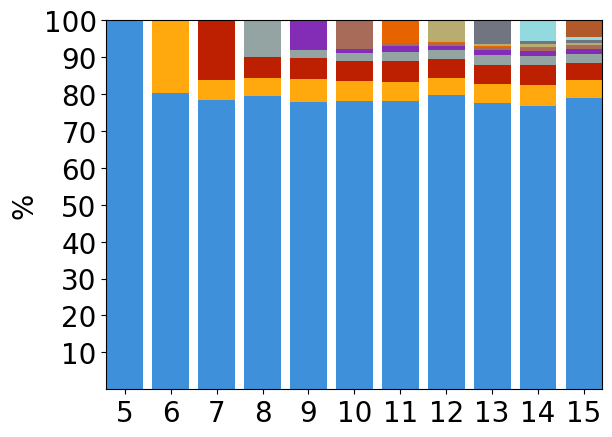

In [42]:
aoa_proportions_ages = getFSAInfo(dfs_ages, False, True)
test = [[aoa_proportions_ages[y][x] for x in range(5,16)] for y in aoa_proportions_ages]
#for t in test:
#    t.reverse()
y = np.column_stack(test)
x = range(5,16)


# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y * 100 
fig = plt.figure()
ax = fig.add_subplot(111)

totals = np.zeros(11)
for i in range(len(percent)):
    current = [y for y in percent[i]]
    ax.bar(x, current, bottom=totals, color=PLOT_COLORS[i])
    totals = np.add(totals, current)


#ax.stackplot(x, percent, labels=PLOT_AGES[::-1], colors=PLOT_COLORS)
#ax.set_title('Age of first appearance for word types within exact ages')
ax.set_ylabel('%', fontsize=20)
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.set_xticks(x)
ax.set_yticks(range(10,110,10))
ax.tick_params(axis='both', labelsize=20)
#ax.legend(PLOT_AGES[::-1])
plt.show()

{'7-8': Counter({5: 3315258, 7: 339316, 6: 250167, 8: 216563}), '9-12': Counter({5: 5723725, 6: 392265, 7: 391312, 9: 219074, 10: 205660, 8: 173152, 12: 130780, 11: 57402}), '13+': Counter({5: 6839756, 6: 461697, 7: 444465, 8: 220337, 13: 194677, 14: 192334, 15: 170364, 9: 110494, 10: 73795, 12: 54225, 11: 31579})}
{'7-8': {5: 0.804, 6: 0.061, 7: 0.082, 8: 0.053}, '9-12': {5: 0.785, 6: 0.054, 7: 0.054, 8: 0.024, 9: 0.03, 10: 0.028, 11: 0.008, 12: 0.018}, '13+': {5: 0.778, 6: 0.053, 7: 0.051, 8: 0.025, 9: 0.013, 10: 0.008, 11: 0.004, 12: 0.006, 13: 0.022, 14: 0.022, 15: 0.019}}
{'7-8': {5: 0.804, 6: 0.061, 7: 0.082, 8: 0.053, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0}, '9-12': {5: 0.785, 6: 0.054, 7: 0.054, 8: 0.024, 9: 0.03, 10: 0.028, 11: 0.008, 12: 0.018, 13: 0.0, 14: 0.0, 15: 0.0}, '13+': {5: 0.778, 6: 0.053, 7: 0.051, 8: 0.025, 9: 0.013, 10: 0.008, 11: 0.004, 12: 0.006, 13: 0.022, 14: 0.022, 15: 0.019}}


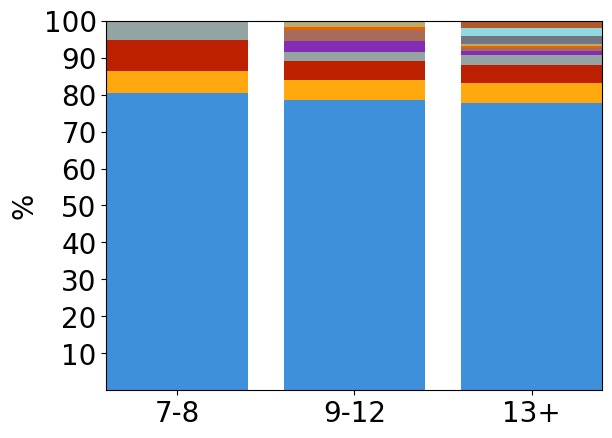

In [43]:
aoa_proportions_groups = getFSAInfo(dfs_groups, False, True)
test = [[aoa_proportions_groups[y][x] for x in range(5,16)] for y in aoa_proportions_groups]
#for t in test:
#    t.reverse()

y = np.column_stack(test)
x = range(0,3)

# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y /  y.sum(axis=0).astype(float) * 100 
fig = plt.figure()
ax = fig.add_subplot(111)
totals = np.zeros(len(x))
for i in range(len(percent)):
    current = [percent[i][y] for y in range(len(x))]
    ax.bar(x, current, bottom=totals, color=PLOT_COLORS[i])
    totals = np.add(totals, current)


#ax.set_title('Age of first appearance for word types within age groups')
ax.set_ylabel('%', fontsize=20)
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.set_xticks(x, labels=SHEET_NAMES_GROUPS)
ax.set_yticks(range(10,110,10))
ax.tick_params(axis='both', labelsize=20)
plt.show()

{'Whole': Counter({8: 113545, 7: 103543, 14: 102731, 15: 100762, 13: 88652, 9: 87932, 10: 84893, 12: 79913, 5: 51882, 6: 40589, 11: 33340})}
{'Whole': {5: 0.058, 6: 0.046, 7: 0.117, 8: 0.128, 9: 0.099, 10: 0.096, 11: 0.038, 12: 0.09, 13: 0.1, 14: 0.116, 15: 0.113}}
{'Whole': {5: 0.058, 6: 0.046, 7: 0.117, 8: 0.128, 9: 0.099, 10: 0.096, 11: 0.038, 12: 0.09, 13: 0.1, 14: 0.116, 15: 0.113}}


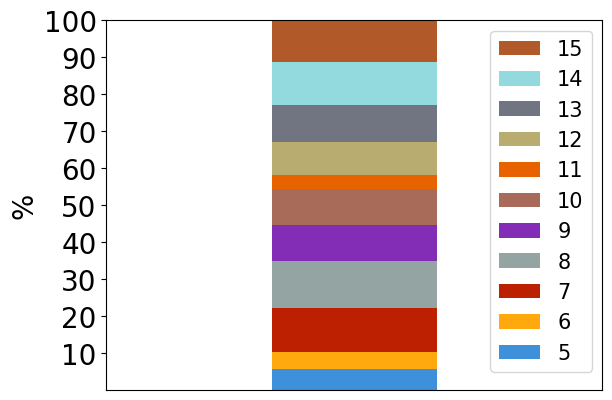

In [33]:
aoa_proportions_whole = getFSAInfo(dfs_whole, False, False)
test = [[aoa_proportions_whole[y][x] for x in range(5,16)] for y in aoa_proportions_whole]

y = np.column_stack(test)
x = range(0,1)

# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y /  y.sum(axis=0).astype(float) * 100 

fig = plt.figure()
ax = fig.add_subplot(111)

totals = np.zeros(len(x))
for i in range(len(percent)):
    current = [percent[i][0]]
    ax.bar(x, current, bottom=totals, color=PLOT_COLORS[i], width=0.5)
    totals = np.add(totals, current)

#ax.set_title('Age of first appearance for word types in TCBLex 1.0')
ax.set_ylabel('%', fontsize=20)
ax.margins(1, 0) # Set margins to avoid "whitespace"
ax.set_yticks(range(10,110,10))
ax.tick_params(axis='both', labelsize=20)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.legend(reverse=True, labels=PLOT_AGES, loc='upper right', fontsize=15)
plt.show()

# Zipf-values plot

In [46]:
import math
def plot_zipf(data: dict[str,pd.Series], column: str, dupe_col: str):
    fig, axs = plt.subplots(1,len(data))
    keys = list(data.keys())
    y_range = [np.inf,-np.inf]
    x_range = [np.inf,-np.inf]
    
    for i in range(len(keys)):
        x = i
        to_plot = data[keys[i]].drop_duplicates(dupe_col)[column]
        bins = np.linspace(np.min(to_plot), np.max(to_plot), 24) - 0.5
        axs[x].hist(to_plot.to_numpy(), bins=bins, color='#1A85FF')
        #axs[y, x].set_xticks(np.linspace(np.min(to_plot), np.max(to_plot) , 5) - 0.5)
        axs[x].set_title(keys[i], fontsize=20)
        per_50 = np.percentile(to_plot, 50)
        per_75 = np.percentile(to_plot, 75)
        per_90 = np.percentile(to_plot, 90)
        axs[x].axvline(per_50, color='#D41159', linestyle='dashed', linewidth=2, label='50th Percentile')
        #axs[x].axvline(per_75, color='#D41159', linestyle='dashed', linewidth=2, label='75th Percentile')
        axs[x].axvline(per_90, color='#D41159', linestyle='dashed', linewidth=2, label='90th Percentile')
    for ax in axs.flat:
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        if x_lim[0] < x_range[0]:
            x_range[0] = x_lim[0]
        if x_lim[1] > x_range[1]:
            x_range[1] = x_lim[1]
        if y_lim[0] < y_range[0]:
            y_range[0] = y_lim[0]
        if y_lim[1] > y_range[1]:
            y_range[1] = y_lim[1]
        ax.set_ylim(0,)
        ax.label_outer()

    for ax in axs.flat:
        ax.set_ylim(y_range)
        ax.set_xlim(x_range)
        ax.set_xlim(2,5)
        space = np.linspace(3, 5, 5)
        ax.set_xticks(space - 0.5)
        y_space = np.linspace(50000, 450000, 9, dtype=int)
        ax.set_yticks(y_space)
        ax.tick_params(axis='both', labelsize=20)
        ax.label_outer()
        

    return fig, axs

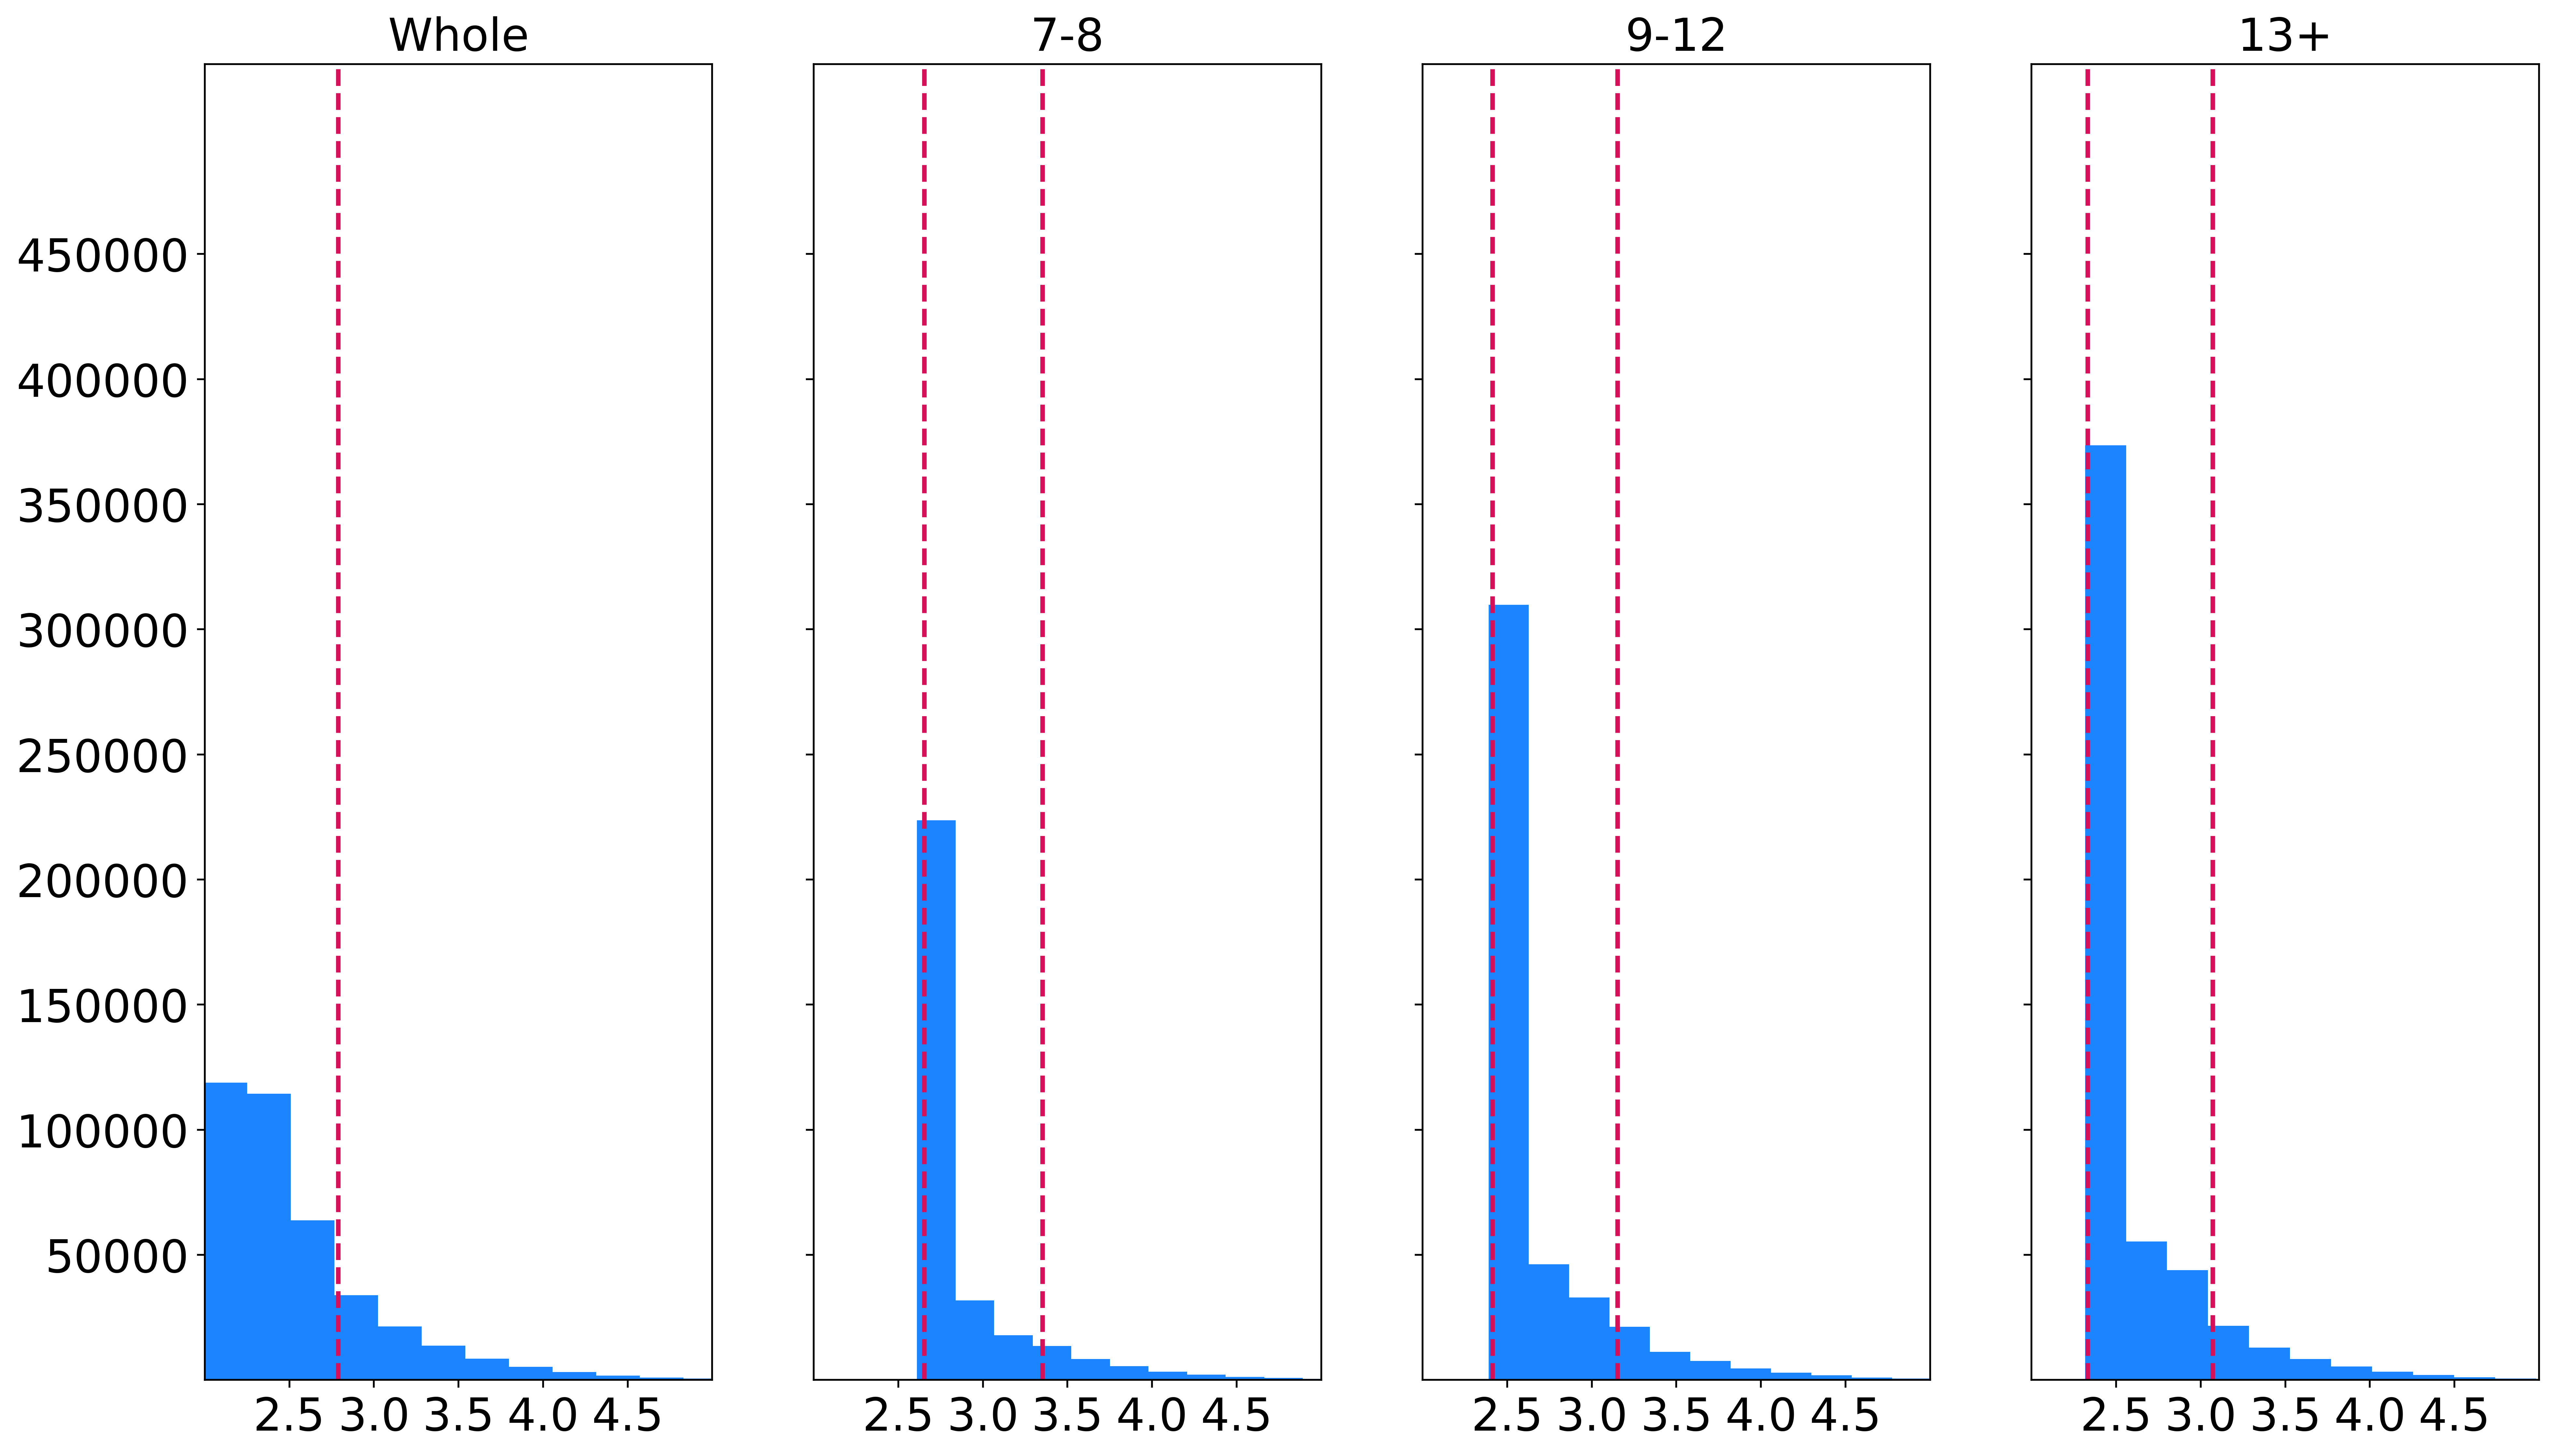

In [47]:
grpwh = bdf.combineSubCorpDicts([dfs_whole, dfs_groups])
fig, axs = plot_zipf(grpwh, 'Word Zipf', 'text')
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(500)

# Morphological paradigm size plot

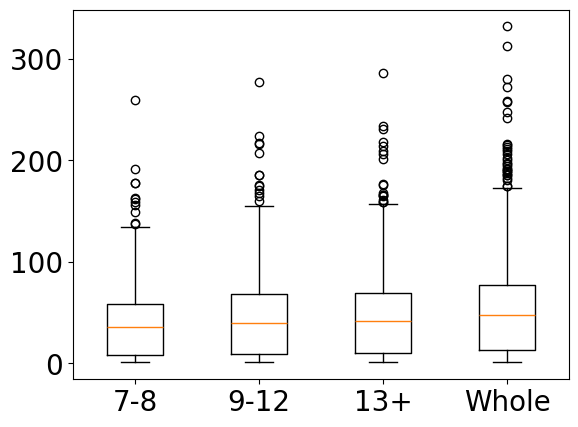

In [36]:
grpwh = bdf.combineSubCorpDicts([dfs_groups, dfs_whole])

datt = [grpwh[sheet][(grpwh[sheet]['Lemma F'] > np.percentile(grpwh[sheet]['Lemma F'], 90))].drop_duplicates('lemma')['Lemma MPS'].to_numpy() for sheet in grpwh]
plt.boxplot(datt)
plt.xticks([1,2,3,4], labels=list(grpwh.keys()))
plt.tick_params(axis='both', labelsize=20)

# Examples of how to query TCBLex using Pandas

In [37]:
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Word SFI'] > 75].drop_duplicates(['text'])))

16


In [38]:
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Lemma MPS'] == 1].drop_duplicates(['lemma'])))

240221


In [39]:
#In how many books
print(len(dfs_whole['Whole'].drop_duplicates('lemma')['lemma']))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] < 0.005].drop_duplicates('lemma')))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] > 0.499].drop_duplicates('lemma')))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] > 0.499].drop_duplicates('lemma')) / len(dfs_whole['Whole'].drop_duplicates('lemma')['lemma']))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] == 1].drop_duplicates('lemma')))
print(dfs_whole['Whole'][dfs_whole['Whole']['Lemma CD'] == 1].drop_duplicates('lemma')['Lemma F'].sum()/dfs_whole['Whole'].drop_duplicates('lemma')['Lemma F'].sum())

352167
270966
1579
0.004483668259660899
14
0.28797524118315765


In [40]:
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Word CD'] < 0.005].drop_duplicates('text')))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Word CD'] > 0.499].drop_duplicates('text')))
print(len(dfs_whole['Whole'][dfs_whole['Whole']['Word CD'] == 1].drop_duplicates('text')))
print(dfs_whole['Whole'][dfs_whole['Whole']['Word CD'] == 1].drop_duplicates('text')['Word F'].sum()/dfs_whole['Whole'].drop_duplicates('text')['Word F'].sum())

665115
1807
5
0.18887099258788315
